In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## STEPS:
#1. Load model
#2. load data
#3. Run inference on 1 sample
#4. Make a wrapper for using scikit learn
#5. Run inference on 1 sample using wrapper
#6. Run shap values using 1 example

In [3]:
#!pip install lightning
#!pip install git+https://github.com/wfondrie/depthcharge.git
#!pip install --force-reinstall lance
#!pip install shap

In [4]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [5]:
ls ../data/

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pkl
uniformed_molecule_pairs_test.pkl


In [6]:
## Params
dataset_path = '../data/merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
best_model_path='../data/best_model_128n_10_layers_20240209.ckpt'

In [7]:
import shap
import matplotlib.pyplot as plt
from src.transformers.embedder import Embedder
from src.config import Config
import dill
from src.train_utils import TrainUtils
from src.transformers.load_data import LoadData
from src.molecular_pairs_set import MolecularPairsSet
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from src.transformers.postprocessing import Postprocessing
import numpy as np
from src.transformers.sklearn_model import SklearnModel
import spectrum_utils.plot as sup

Seed set to 42


In [8]:
config=Config()

In [9]:
# 1. load model
best_model = Embedder.load_from_checkpoint(best_model_path, d_model=int(config.D_MODEL), n_layers=int(config.N_LAYERS))

In [10]:
best_model

Embedder(
  (linear): Linear(in_features=260, out_features=32, bias=True)
  (relu): ReLU()
  (linear_regression): Linear(in_features=32, out_features=1, bias=True)
  (spectrum_encoder): SpectrumTransformerEncoderCustom(
    (peak_encoder): PeakEncoder(
      (mz_encoder): FloatEncoder()
      (int_encoder): FloatEncoder()
      (combiner): Linear(in_features=256, out_features=128, bias=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05,

## load data

In [11]:
# load data
# Load the dataset from the pickle file
with open(dataset_path, 'rb') as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset['molecule_pairs_train']
molecule_pairs_val = dataset['molecule_pairs_val']
molecule_pairs_test= dataset['molecule_pairs_test']
uniformed_molecule_pairs_test = dataset['uniformed_molecule_pairs_test']

<Axes: xlabel='m/z', ylabel='Intensity'>

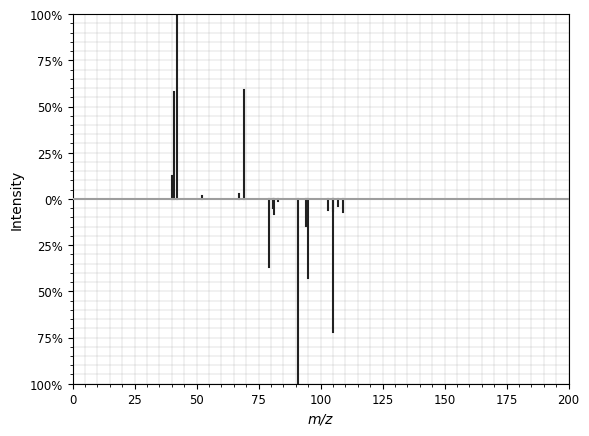

In [12]:
#plot one spectrum from molecule_pairs_test

sup.mirror(uniformed_molecule_pairs_test[0].spectrum_object_0, uniformed_molecule_pairs_test[0].spectrum_object_1)

In [13]:
len(uniformed_molecule_pairs_test)

185165

In [14]:
index = 0

In [15]:
one_molecule_pair  = MolecularPairsSet(spectrums=uniformed_molecule_pairs_test.spectrums, 
                                       indexes_tani = uniformed_molecule_pairs_test.indexes_tani[index:index+1,:])

In [16]:
one_molecule_pair

## Make a wrapper

In [17]:
sklearn_model = SklearnModel(best_model_path, d_model=int(config.D_MODEL), n_layers=int(config.N_LAYERS))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
explainer=sklearn_model.get_explainer(uniformed_molecule_pairs_test)

Preprocessing all the data ...


32486it [00:01, 17466.42it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


32486it [00:00, 67676.64it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


## Select one spectrum as unknown

In [26]:
spectrum_hash_target = molecule_pairs_test.spectrums[0].spectrum_hash

In [27]:
spectrum_hash_target

'fb07ed1d55ba0a804d01'

In [28]:
sklearn_model

SklearnModel(d_model=128,
             model_path='../data/best_model_128n_10_layers_20240209.ckpt',
             n_layers=10)

(array([9.380e+02, 2.930e+03, 6.292e+03, 7.192e+03, 5.623e+03, 3.866e+03,
        2.192e+03, 1.441e+03, 6.440e+02, 4.120e+02, 2.770e+02, 9.700e+01,
        1.730e+02, 9.100e+01, 8.300e+01, 5.000e+01, 5.600e+01, 1.800e+01,
        7.000e+00, 2.900e+01, 2.000e+00, 3.700e+01, 7.000e+00, 0.000e+00,
        1.000e+00, 1.300e+01, 0.000e+00, 8.000e+00, 0.000e+00, 7.000e+00]),
 array([  69.0447    ,  122.81154333,  176.57838667,  230.34523   ,
         284.11207333,  337.87891667,  391.64576   ,  445.41260333,
         499.17944667,  552.94629   ,  606.71313333,  660.47997667,
         714.24682   ,  768.01366333,  821.78050667,  875.54735   ,
         929.31419333,  983.08103667, 1036.84788   , 1090.61472333,
        1144.38156667, 1198.14841   , 1251.91525333, 1305.68209667,
        1359.44894   , 1413.21578333, 1466.98262667, 1520.74947   ,
        1574.51631333, 1628.28315667, 1682.05      ]),
 <BarContainer object of 30 artists>)

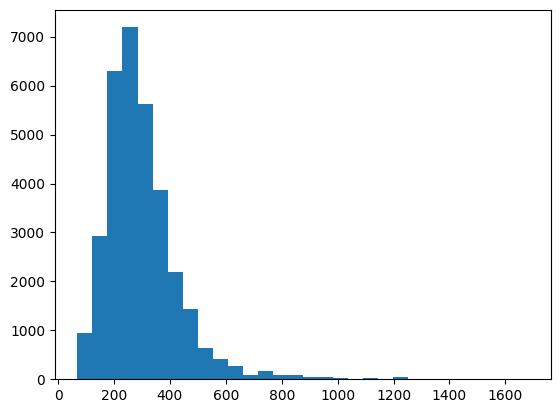

In [192]:
plt.hist([s.precursor_mz for s in molecule_pairs_test.spectrums], bins=30)

In [193]:
from rdkit import Chem
target_index=100
target_spec=molecule_pairs_test.spectrums[target_index]
indexes_tani = np.array([[target_index,i,0] for i,m in enumerate(molecule_pairs_test.spectrums) \
                         if (Chem.CanonSmiles(m.smiles)!= Chem.CanonSmiles(target_spec.smiles)) \
                         and ((m.precursor_mz-target_spec.precursor_mz)<200)and ((m.precursor_mz-target_spec.precursor_mz)>1) \
                        ])
target_molecule_pair = MolecularPairsSet(spectrums=molecule_pairs_test.spectrums,
                                       indexes_tani =indexes_tani)

In [194]:
indexes_tani

array([[  100,   126,     0],
       [  100,   127,     0],
       [  100,   128,     0],
       ...,
       [  100, 19357,     0],
       [  100, 19358,     0],
       [  100, 19359,     0]])

In [172]:
predicted_similarities =sklearn_model.predict_from_molecule_pair(target_molecule_pair)

Preprocessing all the data ...


32486it [00:00, 75550.63it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Prediction has been called


Predicting: |                                                                                                 …

(array([9.8700e+02, 1.5137e+04, 1.2920e+03, 1.1640e+03, 4.9200e+02,
        5.0000e+00, 3.3000e+01, 7.2000e+01, 2.8000e+01, 2.4000e+01]),
 array([-0.08581099,  0.00873751,  0.103286  ,  0.1978345 ,  0.292383  ,
         0.38693149,  0.48147999,  0.57602849,  0.67057698,  0.76512548,
         0.85967398]),
 <BarContainer object of 10 artists>)

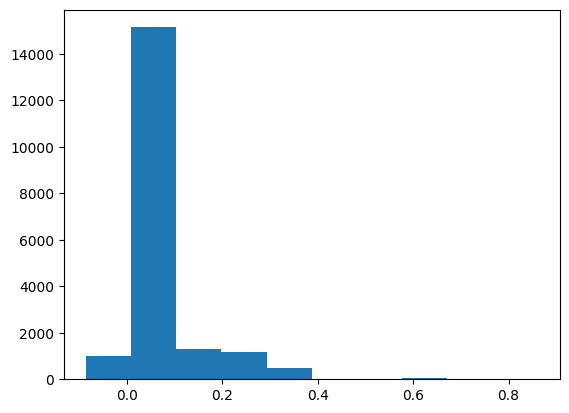

In [173]:
plt.hist(predicted_similarities)

In [174]:
#invalid
#predicted_similarities[predicted_similarities>1]=0

In [175]:
indexes_tani[:,1]

array([  126,   127,   128, ..., 19357, 19358, 19359])

In [176]:
np.flip(np.sort(predicted_similarities))

array([ 0.85967398,  0.85892677,  0.85226977, ..., -0.0748249 ,
       -0.08543327, -0.08581099])

In [180]:
best_indexes=np.flip(np.argsort(predicted_similarities))

In [178]:
target_spec.params

{'libraryquality': 1,
 'charge': [1],
 'pepmass': [101.0597],
 'ionmode': 'Positive',
 'name': ' 3,3-Dimethylacrylic acid\n M+H',
 'inchi': 'N/A',
 'smiles': 'CC(=CC(=O)O)C',
 'organism': 'nist',
 'spectrumid': 'abcd'}

In [188]:
molecule_pairs_test.spectrums[indexes_tani[:,1][best_indexes[4]]].params

{'pepmass': (102.12, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'ESI-QQQ',
 'filename': 'massbank-gnps.mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'MASSBANK',
 'name': 'Massbank:PS008201 Lithum Acetoacetate|3-Keto-n-butyric Acid Lithium Salt|Acetoacetic acid lithium salt|3-oxobutyric acid M+H',
 'pi': 'Massbank',
 'datacollector': 'Massbank',
 'smiles': 'CC(=O)CC(=O)O',
 'inchi': '1S/C4H6O3/c1-3(5)2-4(6)7/h2H2,1H3,(H,6,7)',
 'inchiaux': 'N/A',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '3',
 'spectrumid': 'CCMSLIB00005755869',
 'scans': '30318'}

## Run the inference on the rest of the dataset and find similar molecules

## Run interpretation on 10 spectrums